# Evaluando modelos de clasificación

## Objetivos

Después de completar este laboratorio, podrás:

Implementar y evaluar el desempeño de modelos de clasificación en datos del mundo real

Interpretar y comparar diversas métricas de evaluación y la matriz de confusión para cada modelo

Introducción

En este laboratorio, vas a:

Utilizar el conjunto de datos de cáncer de mama incluido en scikit-learn para predecir si un tumor es benigno o maligno.

Crear dos modelos de clasificación y evaluarlos.

Agregar algo de ruido aleatorio gaussiano a las características para simular errores de medición.

Interpretar y comparar las distintas métricas de evaluación y la matriz de confusión de cada modelo te proporcionará una valiosa intuición sobre lo que significan las métricas de evaluación y cómo pueden influir en tu interpretación del rendimiento de los modelos.

El objetivo de este laboratorio no es encontrar el mejor clasificador; está diseñado principalmente para que practiques la interpretación y comparación de resultados en el contexto de un problema del mundo real.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar el conjunto de datos de Cáncer de Mama

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target
labels = data.target_names
feature_names = data.feature_names

### Imprimimos descripción del resumen del dataset

In [3]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

En resumen, cada observación en el conjunto de datos consiste en una variedad de atributos medidos a partir de una muestra de células de una masa sospechosa tomada de un paciente.
El objetivo es predecir si una masa es maligna (caso positivo) o benigna (caso negativo).

In [4]:
print(data.target_names)

['malignant' 'benign']


### Estandarizar los datos

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

A continuación, agrega algo de ruido para simular errores de medición aleatorios y luego visualiza las primeras filas de las características originales y con ruido para compararlas.

In [6]:
# Add Gaussian noise to the data set
np.random.seed(42)  # For reproducibility
noise_factor = 0.5 # Adjust this to control the amount of noise
X_noisy = X_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

# Load the original and noisy data sets into a DataFrame for comparison and visualization
df = pd.DataFrame(X_scaled, columns=feature_names)
df_noisy = pd.DataFrame(X_noisy, columns=feature_names)

In [7]:
# Display the first few rows of the standardized original and noisy data sets for comparison
print("Original Data (First 5 rows):")
df.head()

Original Data (First 5 rows):


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [8]:
print("\nNoisy Data (First 5 rows):")
df_noisy.head()


Noisy Data (First 5 rows):


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.345421,-2.142467,1.593778,1.745890,1.451390,3.166446,3.442480,2.916193,1.982778,2.527027,...,2.619514,-1.472182,2.337365,1.288863,1.035495,2.672126,1.534030,2.483925,2.450303,1.791168
1,1.528967,0.572507,1.679206,1.379853,-0.415690,-1.097493,0.080586,-0.431691,-0.662701,-0.770222,...,1.967969,-0.561744,1.196665,2.196327,0.139888,0.035196,-0.566358,0.932478,-0.078258,0.768963
2,1.340301,0.363357,1.013336,0.960780,1.348473,1.731046,1.327473,2.538997,1.120503,-0.720568,...,1.402034,0.154582,2.086422,1.197149,0.123161,0.832054,1.312675,2.119376,0.887375,0.458025
3,-0.720371,0.738055,-0.943714,-0.928295,3.087499,2.671152,2.063957,1.582235,2.869940,4.793626,...,-1.240850,0.120727,-0.219824,0.681600,3.298094,4.044171,1.972232,1.591447,6.617453,5.310977
4,2.145813,-1.606510,2.477970,1.125304,0.573800,1.634568,0.875743,1.145344,0.040265,-0.814188,...,1.412305,-0.813199,0.534798,1.313041,0.350498,0.077517,-0.005297,0.069031,-0.607382,-0.248607


Visualizando el contenido de ruido

Puedes obtener una buena idea de cuánta cantidad de ruido hay en las características comparando los valores en las tablas anteriores. También puedes visualizar las diferencias de varias maneras.
Comencemos trazando los histogramas de una de las características con y sin ruido para comparación.

Histogramas

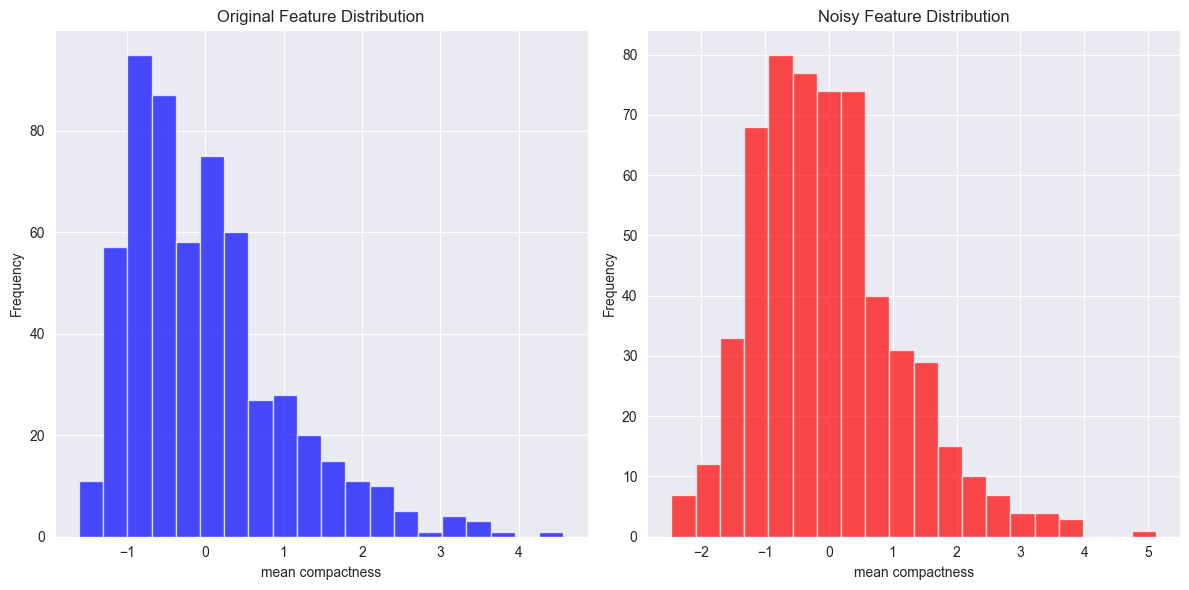

In [9]:
plt.figure(figsize=(12, 6))

# Original Feature Distribution (Noise-Free)
plt.subplot(1, 2, 1)
plt.hist(df[feature_names[5]], bins=20, alpha=0.7, color='blue', label='Original')
plt.title('Original Feature Distribution')
plt.xlabel(feature_names[5])
plt.ylabel('Frequency')

# Noisy Feature Distribution
plt.subplot(1, 2, 2)
plt.hist(df_noisy[feature_names[5]], bins=20, alpha=0.7, color='red', label='Noisy')
plt.title('Noisy Feature Distribution')
plt.xlabel(feature_names[5])
plt.ylabel('Frequency')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

El histograma **sin ruido** está sesgado hacia la izquierda y parece seguir una distribución log-normal, mientras que el histograma **con ruido** está menos sesgado y tiende hacia una distribución normal.


También puedes graficar las dos características juntas para darte una idea de sus diferencias.

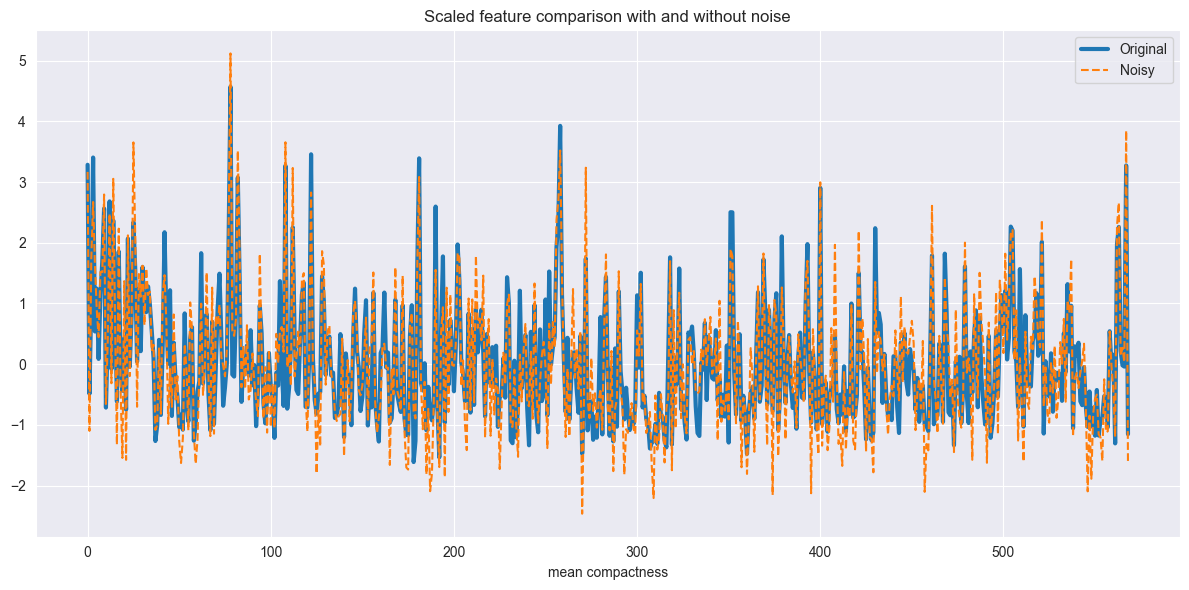

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df[feature_names[5]], label='Original',lw=3)
plt.plot(df_noisy[feature_names[5]], '--',label='Noisy',)
plt.title('Scaled feature comparison with and without noise')
plt.xlabel(feature_names[5])
plt.legend()
plt.tight_layout()
plt.show()

#### Scatterplot
Finalmente, puedes comparar las dos características usando un diagrama de dispersión. Esto te da una excelente idea de qué tan bien están correlacionadas las dos características.

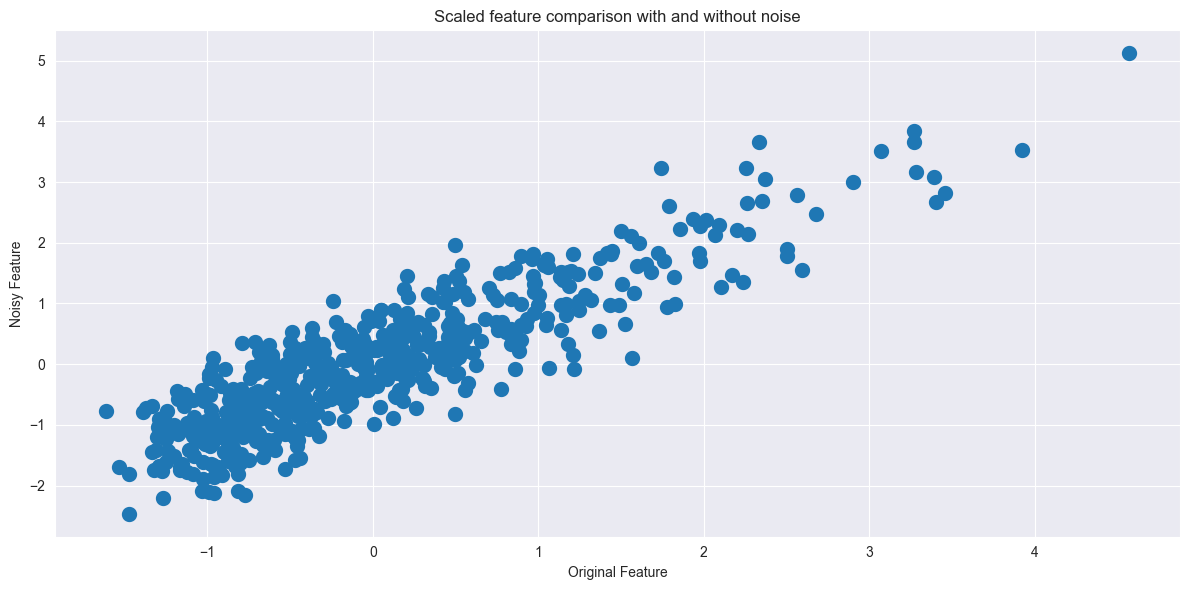

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(df[feature_names[5]], df_noisy[feature_names[5]],lw=5)
plt.title('Scaled feature comparison with and without noise')
plt.xlabel('Original Feature')
plt.ylabel('Noisy Feature')
plt.tight_layout()
plt.show()

### Ejercicio 1. Divide los datos y ajusta los modelos KNN y SVM a los datos de entrenamiento con ruido.

In [12]:
# Split the data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the models
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='linear', C=1, random_state=42)

# Fit the models to the training data
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=42)

### Evalua los módelos

Predecir en el conjunto de prueba

In [13]:
y_pred_knn = knn.predict(X_test)
y_pred_svm = svm.predict(X_test)

Imprime las puntuaciones de exactitud y los informes de clasificación para ambos modelos.

In [14]:
print(f"KNN Testing Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"SVM Testing Accuracy: {accuracy_score(y_test, y_pred_svm):.3f}")

print("\nKNN Testing Data Classification Report:")
print(classification_report(y_test, y_pred_knn))

print("\nSVM Testing Data Classification Report:")
print(classification_report(y_test, y_pred_svm))

KNN Testing Accuracy: 0.936
SVM Testing Accuracy: 0.971

KNN Testing Data Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        63
           1       0.94      0.96      0.95       108

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171


SVM Testing Data Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



#### Grafica las matrices de confusión

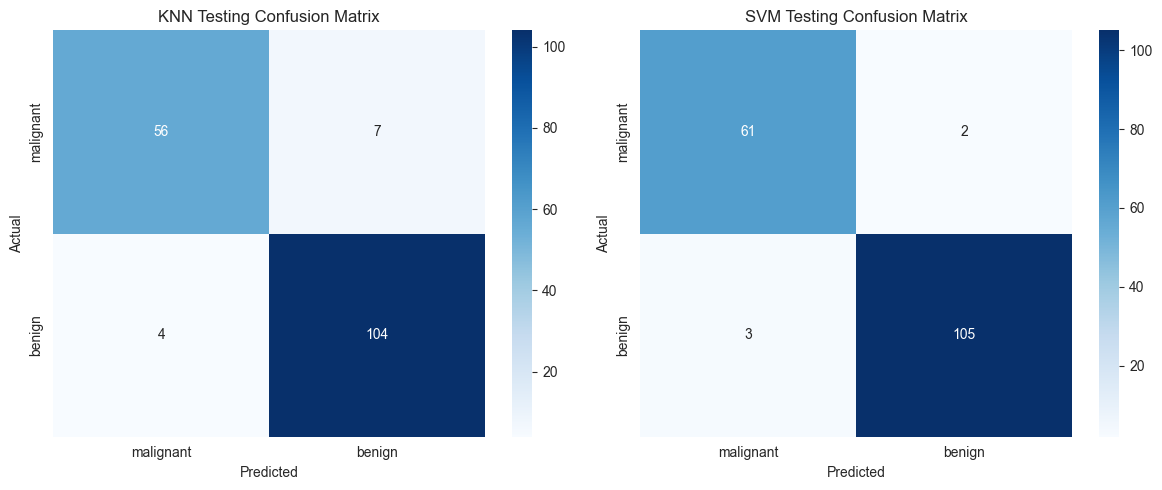

In [15]:
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix_knn, annot=True, cmap='Blues', fmt='d', ax=axes[0],
            xticklabels=labels, yticklabels=labels)

axes[0].set_title('KNN Testing Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_svm, annot=True, cmap='Blues', fmt='d', ax=axes[1],
            xticklabels=labels, yticklabels=labels)
axes[1].set_title('SVM Testing Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Ejercicio 2. ¿Cuál es el peor tipo de error de predicción en este contexto?

Sería ciertamente muy desagradable que te dijeran que tienes cáncer cuando en realidad no lo tienes.
Pero las consecuencias de que te digan que no tienes cáncer cuando en realidad sí lo tienes pueden ser potencialmente mortales.

Expresa este peor escenario en términos de diagnósticos de verdadero/falso positivo/negativo, e identifica sus conteos a partir de las matrices de confusión.

Por convención, un resultado positivo para malignidad significa un diagnóstico de que la masa es maligna.
Por lo tanto, una predicción benigna se considera una predicción negativa.

El peor escenario entonces es un falso negativo, donde el modelo predice incorrectamente que la masa es benigna cuando en realidad es maligna.

Para el modelo KNN, el número de falsos negativos es 7, mientras que para el modelo SVM el conteo es 2.
Podemos decir que el modelo SVM tiene una mayor sensibilidad de predicción que el modelo KNN.

Ejercicio 3. ¿Qué puedes decir para comparar el desempeño general de los dos modelos?

El modelo SVM superó al KNN en términos de precision, recall y F1-score tanto para las clases individuales como en sus promedios generales.
Esto indica que SVM es un clasificador más sólido.
Aunque KNN tuvo un buen desempeño con una precisión del 94%, SVM tiene una mejor capacidad para clasificar correctamente tanto los casos malignos como los benignos, con menos errores.
Dado que el objetivo es elegir el modelo con mejor generalización y menos falsos negativos, SVM es sin duda el clasificador preferido.

Estamos sobreajustando?

Evaluemos los resultados en los datos de entrenamiento y comparémoslos con los resultados en los datos de prueba.

Ejercicio 4. Obtén los resultados de las predicciones usando los datos de entrenamiento.

In [16]:
y_pred_train_knn = knn.predict(X_train)
y_pred_train_svm = svm.predict(X_train)

In [17]:
# Evaluate the models on the training data
print(f"KNN Training Accuracy: {accuracy_score(y_train, y_pred_train_knn):.3f}")
print(f"SVM Training Accuracy: {accuracy_score(y_train, y_pred_train_svm):.3f}")

print("\nKNN Training Classification Report:")
print(classification_report(y_train, y_pred_train_knn))

print("\nSVM Training Classification Report:")
print(classification_report(y_train, y_pred_train_svm))

KNN Training Accuracy: 0.955
SVM Training Accuracy: 0.972

KNN Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       149
           1       0.95      0.98      0.96       249

    accuracy                           0.95       398
   macro avg       0.96      0.95      0.95       398
weighted avg       0.96      0.95      0.95       398


SVM Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       149
           1       0.97      0.99      0.98       249

    accuracy                           0.97       398
   macro avg       0.97      0.97      0.97       398
weighted avg       0.97      0.97      0.97       398



### **Ejercicio 5. Grafica las matrices de confusión para los datos de entrenamiento**


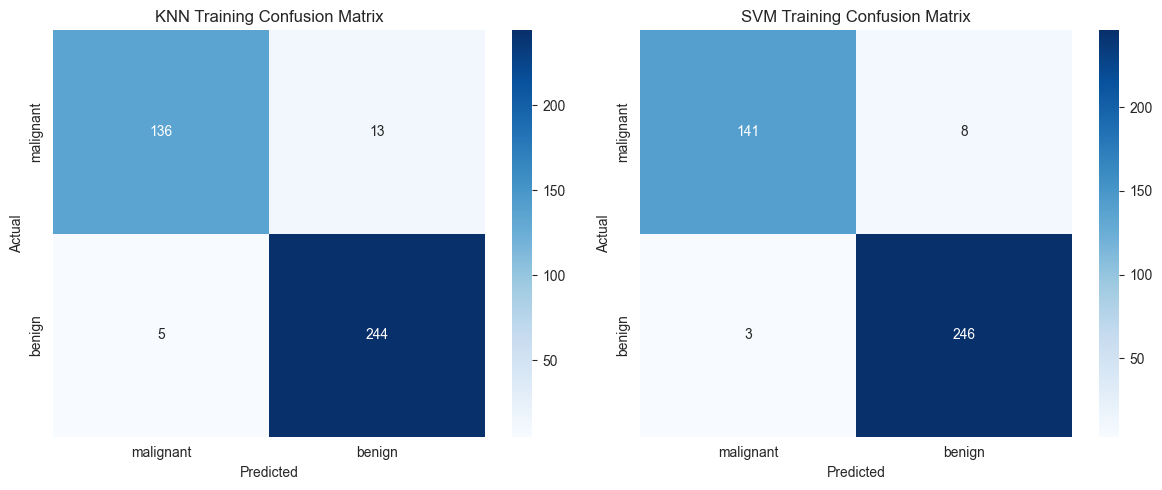

In [18]:
conf_matrix_knn = confusion_matrix(y_train, y_pred_train_knn)
conf_matrix_svm = confusion_matrix(y_train, y_pred_train_svm)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix_knn, annot=True, cmap='Blues', fmt='d', ax=axes[0],
            xticklabels=labels, yticklabels=labels)

axes[0].set_title('KNN Training Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_svm, annot=True, cmap='Blues', fmt='d', ax=axes[1],
            xticklabels=labels, yticklabels=labels)
axes[1].set_title('SVM Training Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Ejercicio 6. Comparación de las precisiones de entrenamiento y prueba para ambos modelos

¿Qué puedes decir sobre la precisión de los dos modelos en los conjuntos de entrenamiento y prueba?
¿Qué podrían indicar estos resultados?

Idealmente, la exactitud (accuracy) de un modelo debería ser casi la misma tanto en los datos de entrenamiento como en los de prueba.

Sería inusual que la exactitud fuera mayor en el conjunto de prueba, y esto podría ocurrir por azar o por algún tipo de data leakage. Por ejemplo, aquí hemos normalizado todos los datos en conjunto, en lugar de ajustar el StandardScaler con los datos de entrenamiento y luego aplicarlo por separado al conjunto de entrenamiento y al de prueba. Revisaremos este y otros problemas en otro laboratorio.

Cuando la exactitud es sustancialmente mayor en los datos de entrenamiento que en los de prueba, es probable que el modelo esté memorizando detalles del conjunto de entrenamiento que no se generalizan a datos no vistos —es decir, el modelo está sobreajustando (overfitting) a los datos de entrenamiento.

| Modelo | Fase    | Exactitud |
|--------|---------|-----------|
| KNN    | Entrenamiento | 95.5% |
| KNN    | Prueba        | 93.6% |
| SVM    | Entrenamiento | 97.2% |
| SVM    | Prueba        | 97.1% |


Para el modelo SVM, las exactitudes de entrenamiento y prueba son esencialmente las mismas, alrededor del 97%. Esto es ideal: el modelo SVM probablemente no está sobreajustado.
Para el modelo KNN, sin embargo, la exactitud de entrenamiento es aproximadamente un 2% mayor que la exactitud de prueba, lo que indica que podría existir cierto sobreajuste.

En resumen, el modelo SVM es más convincente y además tiene una mayor exactitud que el modelo KNN.
Recuerda, no estamos tratando de ajustar estos modelos; solo estamos comparando su desempeño con un conjunto fijo de hiperparámetros.